In [2]:
!pip install -q rasterio
!pip install -q geopandas
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly
!pip install focal-loss
!pip install tensorflow-addons
!pip install tensorflow==2.13.0

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-wn8_1q83
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-wn8_1q83
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=cedf37c9e8cfd498fba6432fb588b769f9f5f58f590cf970829f63e1a1532f84
  Stored in directory: /tmp/pip-ephem-wheel-cache-ssscmydq/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
  Using cached dm_tree-0.1.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached immutabledict-4.2.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached simple_par

In [4]:
from zipfile import ZipFile
from itertools import product
import os, glob, functools, fnmatch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features, mask, windows

import geopandas as gpd

import tensorflow as tf
from tensorflow.python.keras import layers, losses, models
from tensorflow.python.keras import backend as K  
import tensorflow_addons as tfa

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output

from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import confusion_matrix, f1_score

In [16]:
root_dir = 'images/'
# sentinel_timestamps = ['2017-01-01', '2017-03-22', '2017-05-31', '2017-06-20',
#                        '2017-08-04', '2017-07-15', '2017-08-19', '2017-01-31']
# test_sentinel_timestamp = ['2017-07-10', '2017-02-10']
# target_crs = 'epsg:32734'

sentinel_timestamps = ['2017-03-22', '2017-05-31', '2017-06-20', '2017-08-04']
test_sentinel_timestamp = ['2017-07-10']
target_crs = 'epsg:32734'

In [17]:
class_index = pd.read_csv('crop_id_list.csv')
class_names = class_index.crop.unique()
print(class_index)

   crop_id                            crop
0        1                          Cotton
1        2                           Dates
2        3                           Grass
3        4                          Lucern
4        5                           Maize
5        6                           Pecan
6        7                          Vacant
7        8                        Vineyard
8        9  Vineyard & Pecan ("Intercrop")


In [6]:
def sentinel_read(sentinel_timestamp):
    sentinel_dir = os.path.join(root_dir, sentinel_timestamp)
    print(sentinel_dir+'/**/*.jp2')
    bands = glob.glob(sentinel_dir+'/**/*.jp2', recursive=True)
    # Read band metadata and arrays
    # metadata
    src_2 = rasterio.open(fnmatch.filter(bands, '*B02.jp2')[0]) #blue
    src_3 = rasterio.open(fnmatch.filter(bands, '*B03.jp2')[0]) #green
    src_4 = rasterio.open(fnmatch.filter(bands, '*B04.jp2')[0]) #red
    src_8 = rasterio.open(fnmatch.filter(bands, '*B08.jp2')[0]) #near infrared

    # array
    arr_2 = src_2.read()
    arr_3 = src_3.read()
    arr_4 = src_4.read()
    arr_8 = src_8.read()
    return sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8

In [7]:
def indexnormstack(red, nir):

    def NDIcalc(nir, red):
        ndi = (nir - red) / (nir + red + 1e-5)
        return ndi

    def WRDVIcalc(red, nir):
        a = 0.2
        wdrvi = (a * nir - red) / (a * nir + red)
        return wdrvi

    def SAVIcalc(red, nir):
        savi = 1.5 * (nir - red) / (nir + red + 0.5)
        return savi

    def norm(arr):
        arr_norm = (255*(arr - np.min(arr))/np.ptp(arr))
        return arr_norm

    ndvi = NDIcalc(nir, red)

    savi = SAVIcalc(red, nir)

    wdrvi = WRDVIcalc(red, nir)

    ndvi = ndvi.transpose(1, 2, 0)
    savi = savi.transpose(1, 2, 0)
    wdrvi = wdrvi.transpose(1, 2, 0)

    index_stack = np.dstack((ndvi, savi, wdrvi))

    return index_stack

In [8]:
def label(geo, src_8):
    geo = gpd.read_file(geo)
    # check for and remove invalid geometries
    geo = geo.loc[geo.is_valid] 
    # reproject training data into local coordinate reference system
    geo = geo.to_crs(crs={'init': target_crs})
    # convert the class identifier column to type integer
    geo['Crop_Id_Ne_int'] = geo.Crop_Id_Ne.astype(int)
    # pair the geometries and their integer class values
    shapes = ((geom, value) for geom, value in zip(geo.geometry, geo.Crop_Id_Ne_int)) 
    # get the metadata (height, width, channels, transform, CRS) to use in constructing the labeled image array
    src_8_prf = src_8.profile
    # construct a blank array from the metadata and burn the labels in
    labels = features.rasterize(shapes=shapes, out_shape=(src_8_prf['height'], src_8_prf['width']), fill=0, all_touched=True, transform=src_8_prf['transform'], dtype=src_8_prf['dtype'])
    print("Values in labeled image: ", np.unique(labels))
    return labels

In [ ]:
def save_images(sentinel_dir, index_stack, labels, src_8):
    index_stack = (index_stack * 255).astype(np.uint8)
    index_stack_t = index_stack.transpose(2, 0, 1)
    labels = labels.astype(np.uint8)

    index_stack_out = rasterio.open(sentinel_dir+'/index_stack.tiff', 'w', driver='Gtiff',
                              width=src_8.width, height=src_8.height,
                              count=3,
                              crs=src_8.crs,
                              transform=src_8.transform,
                              dtype='uint8')

    index_stack_out.write(index_stack_t)
    index_stack_out.close()

    labels_out=rasterio.open(sentinel_dir+'/labels.tiff', 'w', driver='Gtiff',
                              width=src_8.width, height=src_8.height,
                              count=1,
                              crs=src_8.crs,
                              transform=src_8.transform,
                              dtype='uint8')

    labels_out.write(labels, 1)
    labels_out.close()

    return sentinel_dir+'/index_stack.tiff', sentinel_dir+'/labels.tiff'
# Now let's divide the Sentinel 2 index stack and labeled image into 224x224 pixel tiles

In [ ]:
def tile(index_stack, labels, sentinel_timestamp):
    tiles_dir = root_dir+'tiled/'
    img_dir = root_dir+'tiled/images/'
    # img_dir = root_dir+'tiled/images_test/'
    label_dir = root_dir+'tiled/labels/'
    # label_dir = root_dir+'tiled/labels_test/'
    dirs = [tiles_dir, img_dir, label_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)

    # set tile height and width
    # height, width = 224, 224

    def get_tiles(ds, width=224, height=224):
        # get number of rows and columns (pixels) in the entire input image
        nols, nrows = ds.meta['width'], ds.meta['height']
        # get the grid from which tiles will be made 
        offsets = product(range(0, nols, width), range(0, nrows, height))
        # get the window of the entire input image
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        # tile the big window by mini-windows per grid cell
        for col_off, row_off in offsets:
            window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform

    # tile_width, tile_height = 224, 224

    def crop(inpath, outpath, c):
        # read input image
        image = rasterio.open(inpath)
        # get the metadata 
        meta = image.meta.copy()
        # set the number of channels to 3 or 1, depending on if its the index image or labels image
        meta['count'] = int(c)
        # set the tile output file format to PNG (saves spatial metadata unlike JPG)
        meta['driver']='PNG'
        # tile the input image by the mini-windows
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = outpath+"tile_%s_%s.png" % (sentinel_timestamp, str(i))
            with rasterio.open(outfile, 'w', **meta) as outds:
                outds.write(image.read(window=window))
            i = i+1
            
    def process_tiles(index_flag):
        # tile the input images, when index_flag == True, we are tiling the spectral index image, 
        # when False we are tiling the labels image
        if index_flag==True:
            inpath = sentinel_dir+'/index_stack.tiff'
            print(inpath)
            outpath=img_dir
            crop(inpath, outpath, 3)
        else:
            inpath = sentinel_dir+'/labels.tiff'
            outpath=label_dir
            crop(inpath, outpath, 1)
                
    process_tiles(index_flag=True) # tile index stack
    process_tiles(index_flag=False) # tile labels
    return tiles_dir, img_dir, label_dir

In [10]:
# import zipfile

# # Path to the zip file containing Sentinel-SAFE data
# for root, dirs, files in os.walk("images"):
#     for file_name in files:
#         if file_name.endswith('.zip'):
#             zip_file_path = 'images/' + file_name
#             extracted_dir = 'images/' + file_name[:-4]

#             with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#                 zip_ref.extractall(extracted_dir)
#             print(file_name)

# Find and open band 2 data within the extracted directory
# for root, dirs, files in os.walk(extracted_dir):
#     for file_name in files:
#         if file_name.endswith('_B01.jp2'):
#             band2_path = os.path.join(root, file_name)
#             with rasterio.open(band2_path) as dataset:
#                 # Read metadata
#                 print(dataset.profile)
                
#                 # Read band 2 data
#                 band2_data = dataset.read(1)  # Assuming band 2 is the first band (index 1-based)
                # If you need to apply any transformation to the data (e.g., scaling), you can do it here

# Now you have band 2 data in the 'band2_data' variable, which you can use for further processing or visualization

In [85]:
# If you want to write the files out to your personal drive,
# set write_out = True, but I recommend trying
# that in your free time because it takes about 4 hours for all 8 training Sentinel timetamps,
# and about 1 minutes for the 2 test timestamps.

write_out = True
if write_out is True:
    for timestamp in sentinel_timestamps:
        # timestamp, tiles_dir, img_dir, label_dir = main(timestamp)
        print("timestamp: ", timestamp)
        sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8 = sentinel_read(timestamp)
        # Calculate indices and combine the indices into one single 3 channel image
        index_stack = indexnormstack(arr_4, arr_8)

        # Rasterize labels
        labels = label('train/train.shp', src_8)

        # reset the path of the Sentinel 2 image directory to your personal drive 
        # if you want to write the files out
        sentinel_dir = os.path.join("result", timestamp)
        if not os.path.exists(sentinel_dir):
            os.makedirs(sentinel_dir)
        print(sentinel_dir, src_8)

        # Save index stack and labels to geotiff
        index_stack_file, labels_file = save_images(sentinel_dir, index_stack, labels, src_8)

        # Tile images into 224x224
        tiles_dir, img_dir, label_dir = tile(index_stack, labels, timestamp)
        print("done")
else:
    print("Not writing to file; using data in shared drive too.")

timestamp:  2017-03-22
images/2017-03-22/**/*.jp2


/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Values in labeled image:  [0 1 2 3 4 5 6 7 8 9]
result/2017-03-22 <open DatasetReader name='images/2017-03-22/S2A_MSIL1C_20170322T081611_N0204_R121_T34JEP_20170322T084728.SAFE/GRANULE/L1C_T34JEP_A009127_20170322T084728/IMG_DATA/T34JEP_20170322T081611_B08.jp2' mode='r'>
done
timestamp:  2017-05-31
images/2017-05-31/**/*.jp2


/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Values in labeled image:  [0 1 2 3 4 5 6 7 8 9]
result/2017-05-31 <open DatasetReader name='images/2017-05-31/S2A_MSIL1C_20170531T082011_N0205_R121_T34JEP_20170531T084246.SAFE/GRANULE/L1C_T34JEP_A010128_20170531T084246/IMG_DATA/T34JEP_20170531T082011_B08.jp2' mode='r'>
done
timestamp:  2017-06-20
images/2017-06-20/**/*.jp2


/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Values in labeled image:  [0 1 2 3 4 5 6 7 8 9]
result/2017-06-20 <open DatasetReader name='images/2017-06-20/S2A_MSIL1C_20170620T082011_N0205_R121_T34JEP_20170620T084200.SAFE/GRANULE/L1C_T34JEP_A010414_20170620T084200/IMG_DATA/T34JEP_20170620T082011_B08.jp2' mode='r'>
done
timestamp:  2017-08-04
images/2017-08-04/**/*.jp2


/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Values in labeled image:  [0 1 2 3 4 5 6 7 8 9]
result/2017-08-04 <open DatasetReader name='images/2017-08-04/S2B_MSIL1C_20170715T081609_N0205_R121_T34JEP_20170715T084650.SAFE/GRANULE/L1C_T34JEP_A001863_20170715T084650/IMG_DATA/T34JEP_20170715T081609_B08.jp2' mode='r'>
done


In [18]:
# set the paths to point to the tiles images
tiles_dir = root_dir+'tiled/'

# train
img_dir = root_dir+'tiled/images/'
label_dir = root_dir+'tiled/labels/'

# test
test_img_dir = root_dir+'tiled/images_test/'
test_label_dir = root_dir+'tiled/labels_test/'

In [19]:
# get initial counts of train and test images
%ls $img_dir | wc -l
%ls $test_img_dir | wc -l 

20000
5000


In [20]:

def get_train_test_lists(imdir, lbldir):
  imgs = glob.glob(imdir+"/*.png")
  # print(imgs)
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)
    
  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    # print(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))
    
  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames

In [21]:
train_list, x_train_filenames, y_train_filenames = get_train_test_lists(img_dir, label_dir)

number of images:  10000


In [22]:
test_list, x_test_filenames, y_test_filenames = get_train_test_lists(test_img_dir, test_label_dir)

number of images:  2500


In [23]:
skip = False

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      img = np.array(Image.open(label_dir+"{}.png".format(i))) 
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)
          
  print("number of background training images: ", len(background_list_train))

  background_list_test = []
  for i in test_list: 
      img = np.array(Image.open(test_label_dir+"{}.png".format(i))) 
      if img.max()==0:
          background_list_test.append(i)
          
  print("number of background test images: ", len(background_list_test))

  with open(os.path.join("",'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)
  with open(os.path.join("",'background_list_test.txt'), 'w') as f:
    for item in background_list_test:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("number of background training images: ", len(background_list_train))
  
  background_list_test = [line.strip() for line in open("background_list_test.txt", 'r')]
  print("number of background test images: ", len(background_list_test))

number of background training images:  9620
number of background test images:  2405


In [24]:
background_removal = len(background_list_train) * 0.9
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
for img_id in train_list_clean: 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))
    
print(len(train_list_clean))

1342


In [25]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.1, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 1207
Number of validation examples: 135
Number of test examples: 2500


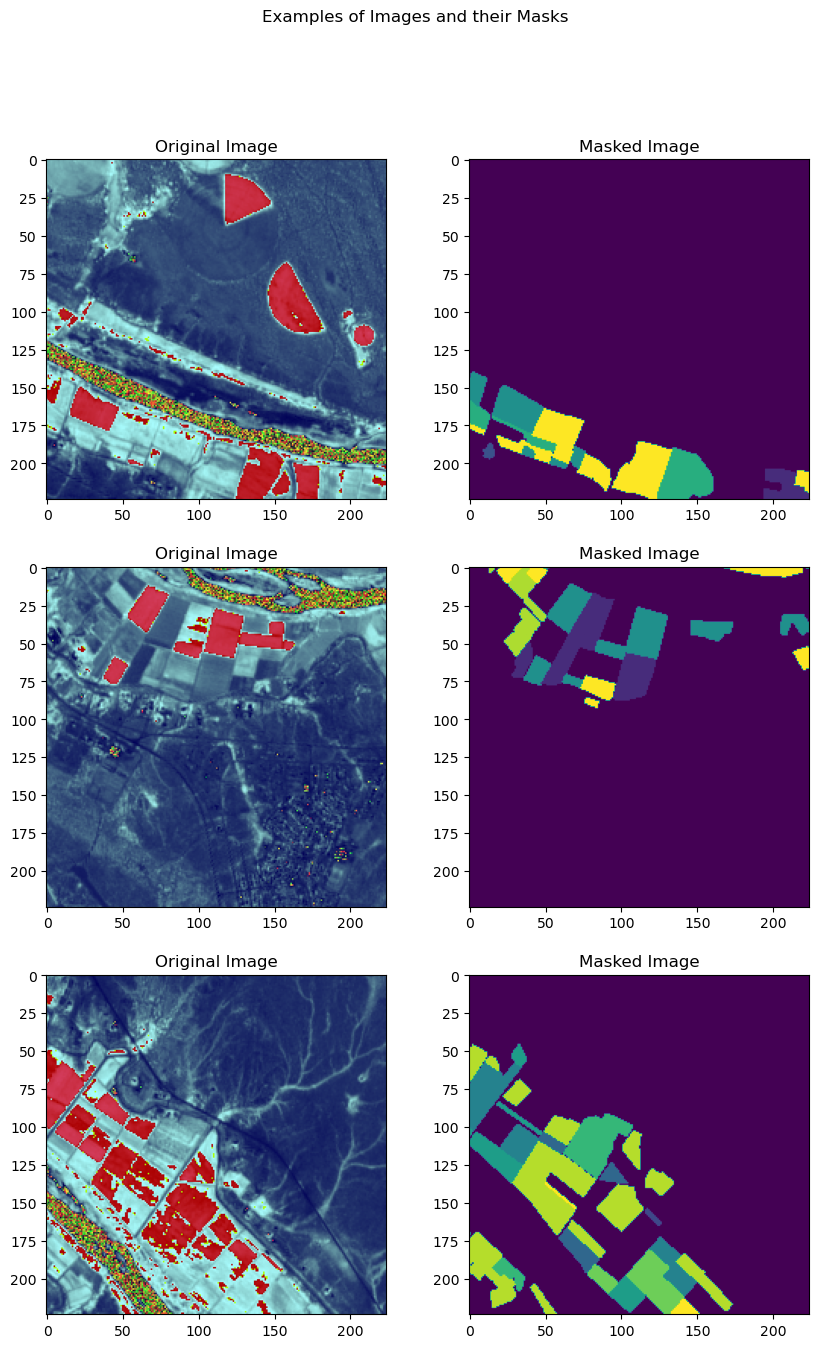

In [29]:
display_num = 3

# select only for tiles with foreground labels present
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

# randomlize the choice of image and label pairs
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  
  original_image.save(f'original_image_{i}.png')
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [27]:
# set input image shape
img_shape = (224, 224, 3)
# set batch size for model
batch_size = 2

In [21]:
# Function for reading the tiles into TensorFlow tensors
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_png(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)

    # These are png images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_png(label_img_str, channels=1)
    # The label image should have any values between 0 and 9, indicating pixel wise
    # cropt type class or background (0). We take the first channel only. 
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

In [22]:
# Function to augment the data with horizontal flip
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [23]:
# Function to augment the data with vertical flip
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [24]:
# Function to augment the images and labels
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             horizontal_flip=False,
             vertical_flip=False): 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    img, label_img = flip_img_h(horizontal_flip, img, label_img)
    img, label_img = flip_img_v(vertical_flip, img, label_img)
    img = tf.cast(img, tf.float32) * scale  #tf.to_float(img) * scale 
    #label_img = tf.cast(label_img, tf.float32) * scale
    #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
    return img, label_img

In [25]:
# Main function to tie all of the above four dataset processing functions together 
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)

    # It's necessary to repeat our data for all epochs
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [26]:
# dataset configuration for training
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [27]:
# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [28]:
# dataset configuration for testing
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)

In [12]:
# create the TensorFlow datasets
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)
test_ds = get_baseline_dataset(x_test_filenames,
                               y_test_filenames,
                               preproc_fn=test_preprocessing_fn,
                               batch_size=batch_size)

NameError: name 'get_baseline_dataset' is not defined

In [30]:
# Now we will display some samples from the datasets
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0, :, :, :]

In [31]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

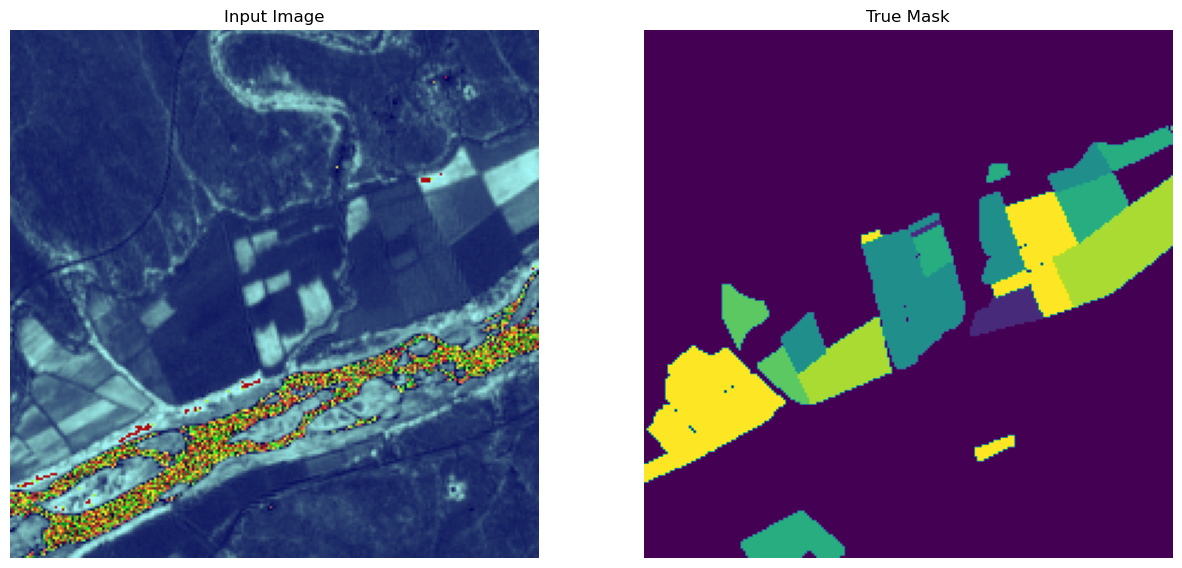

In [32]:
# display sample train image
display([sample_image, sample_mask])

In [11]:
# reset the forground list to capture the validation images
foreground_list_x = []
foreground_list_y = []
for x, y in zip(x_val_filenames, y_val_filenames):
    img = np.array(Image.open(y))
    if img.max() > 0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=val_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0, :, :, :]

# display sample validation image
display([sample_image, sample_mask])

NameError: name 'x_val_filenames' is not defined

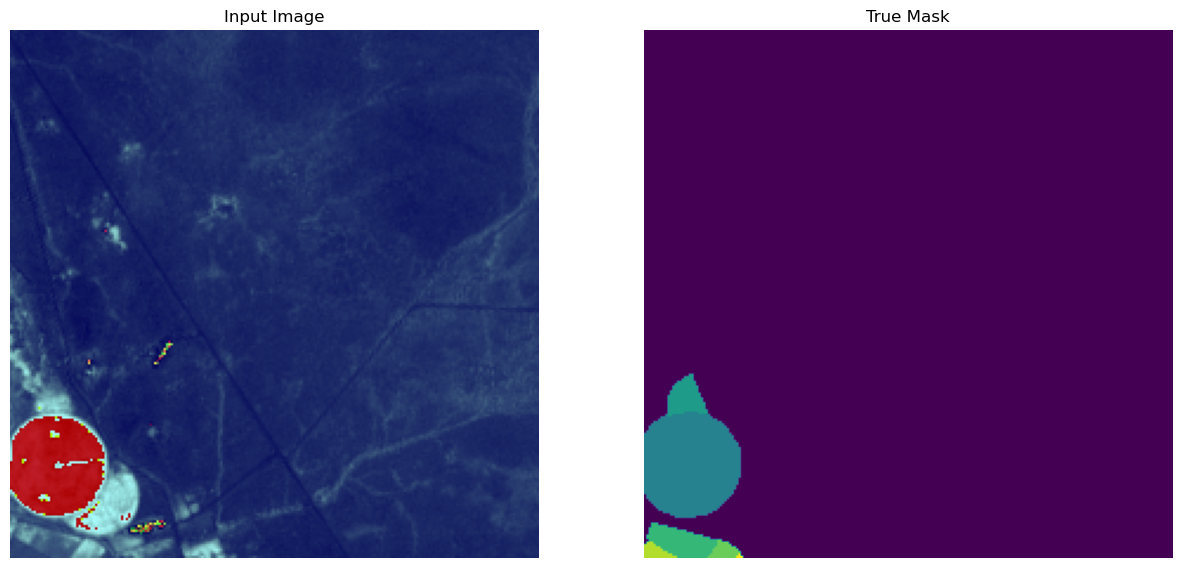

In [34]:
# reset the forground list to capture the test images
foreground_list_x = []
foreground_list_y = []
for x, y in zip(x_test_filenames, y_test_filenames):
    img = np.array(Image.open(y))
    if img.max() > 0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1],
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0, :, :, :]

# display sample test image
display([sample_image, sample_mask])

In [36]:
# set number of model output channels to the number of classes (including background)
OUTPUT_CHANNELS = 10

base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [38]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  # 64x64 -> 224x224

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [40]:
model = unet_model(OUTPUT_CHANNELS)
train_df = pd.read_csv('Farmpin_training.csv')
inv_freq = np.array(1/(train_df.crop_id.value_counts()/len(train_df)))
inv_freq = [0., *inv_freq]
class_weights = {0: inv_freq[0], 1: inv_freq[1], 2: inv_freq[2], 3: inv_freq[3],
                 4: inv_freq[4], 5: inv_freq[5], 6: inv_freq[6],
                 7: inv_freq[7], 8: inv_freq[8], 9: inv_freq[9]}
class_weights

{0: 0.0,
 1: 2.647932131495228,
 2: 4.6585820895522385,
 3: 8.823321554770319,
 4: 9.352059925093632,
 5: 16.98639455782313,
 6: 17.58450704225352,
 7: 26.28421052631579,
 8: 32.42857142857143,
 9: 356.7142857142857}

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True),
              metrics=['accuracy'])

1/1 [==============================] - 1s 1s/step


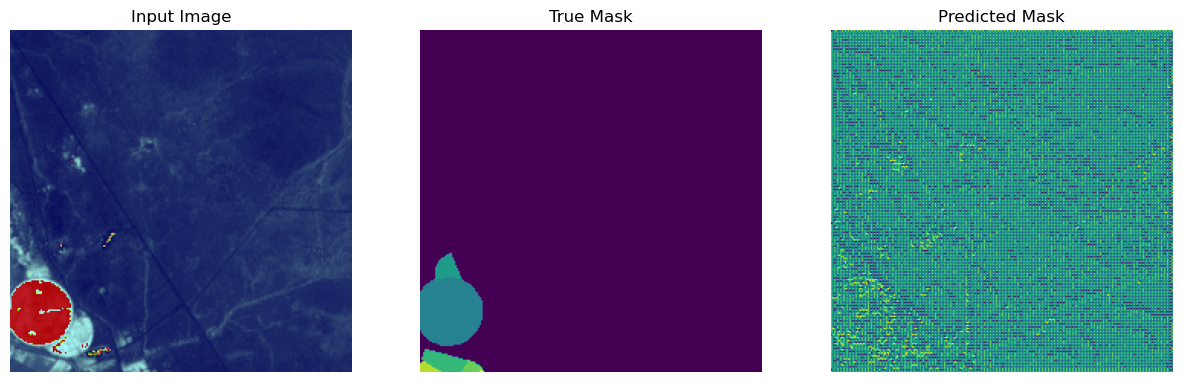

In [43]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        mpe = tf.keras.backend.eval(mp)
        display([sample_image, sample_mask, mpe])


show_predictions()

In [44]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1)

1/1 [==============================] - 0s 150ms/step


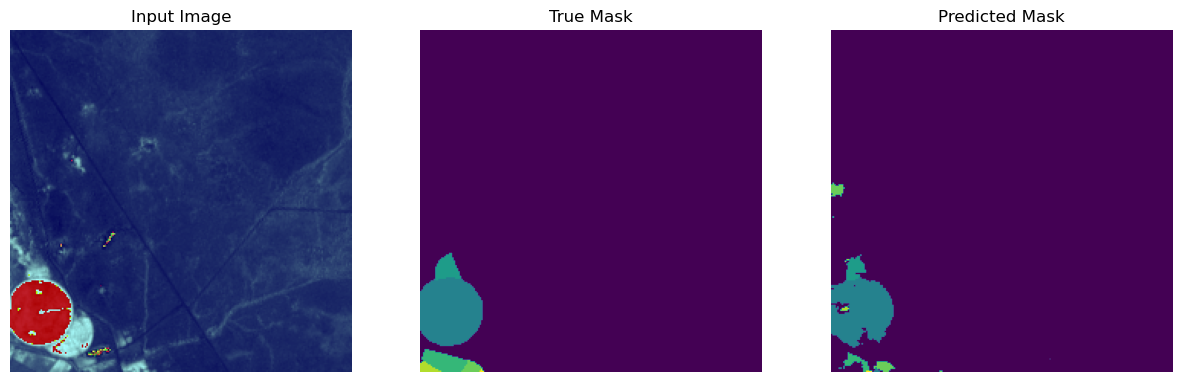


Sample Prediction after epoch 100

604/604 [==============================] - 180s 298ms/step - loss: 0.0050 - accuracy: 0.9946 - val_loss: 0.0616 - val_accuracy: 0.9806


In [ ]:
EPOCHS = 100
model_history=model.fit(
                   train_ds,
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[DisplayCallback()])

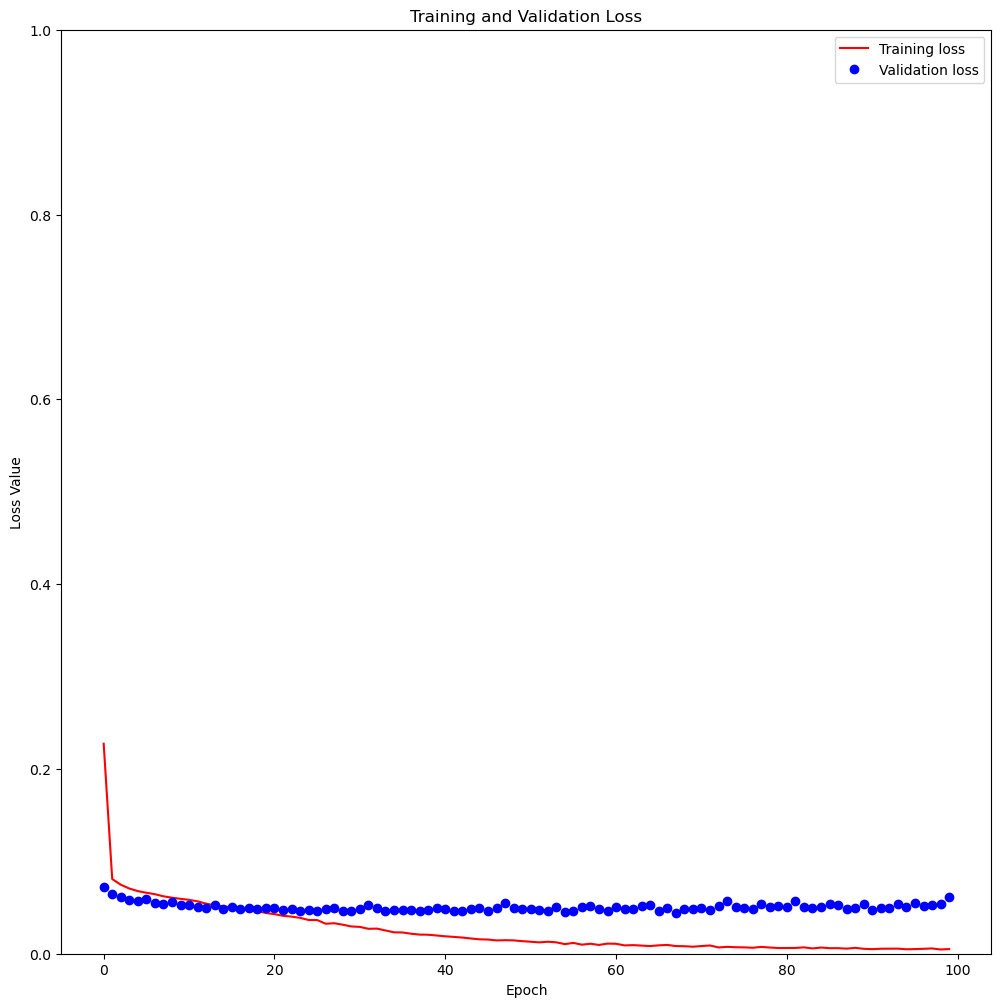

In [46]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [6]:
save_model_path = os.path.join("",'trained_model_4_images/')
# if (not os.path.isdir(save_model_path)):
#     os.mkdir(save_model_path)
# model.save(save_model_path)

In [7]:
# Optional, you can load the model from the saved version
load_from_checkpoint = True
if load_from_checkpoint == True:
  model = tf.keras.models.load_model(save_model_path)
else:
  print("inferencing from in memory model")

In [8]:
def get_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            return pred_mask
    else:
        pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        pred_mask = tf.keras.backend.eval(pred_mask)
        return pred_mask

In [10]:
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1],
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0, :, :, :]

# run and plot predicitions
pred_mask = get_predictions()

show_predictions()

NameError: name 'num_foreground_examples' is not defined

['images/tiled/labels_test/tile_2017-07-10_769.png']
[0 8]
1/1 [==============================] - 0s 160ms/step


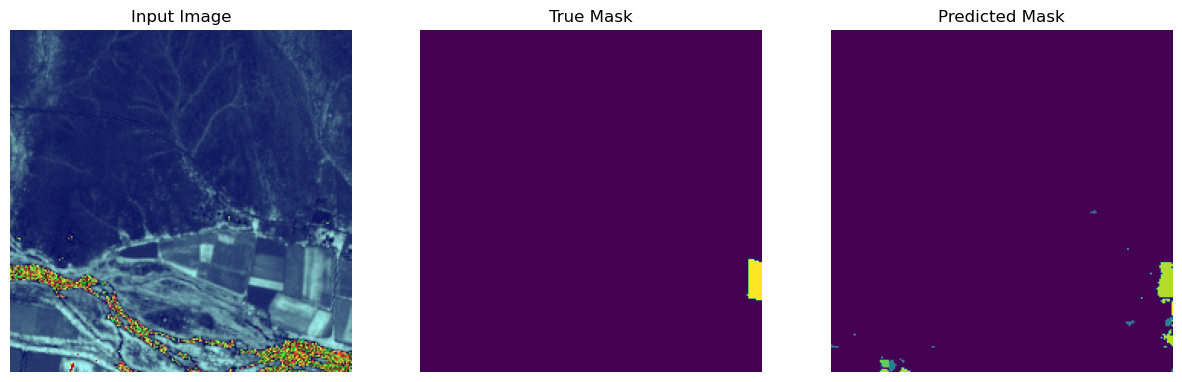

1/1 [==============================] - 0s 118ms/step
['images/tiled/labels_test/tile_2017-07-10_819.png']
[0 6 8]
1/1 [==============================] - 0s 94ms/step


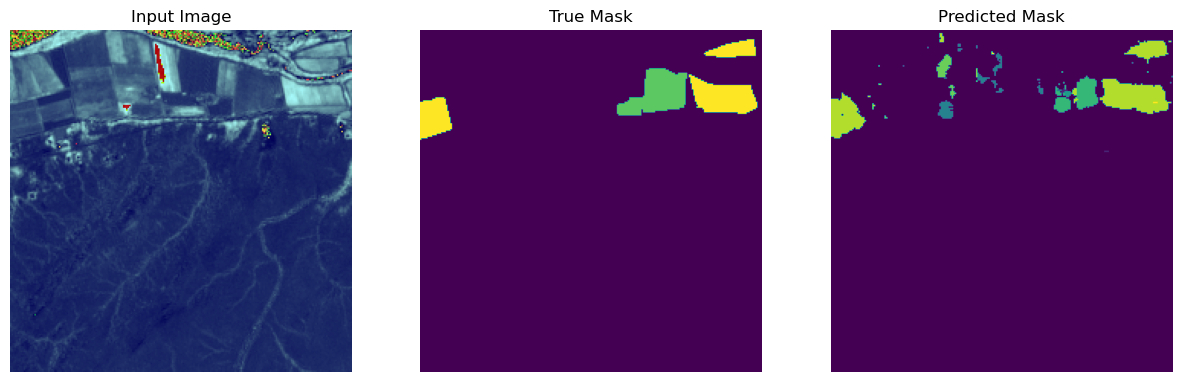

1/1 [==============================] - 0s 94ms/step
['images/tiled/labels_test/tile_2017-07-10_869.png']
[0 5 7 8]
1/1 [==============================] - 0s 99ms/step


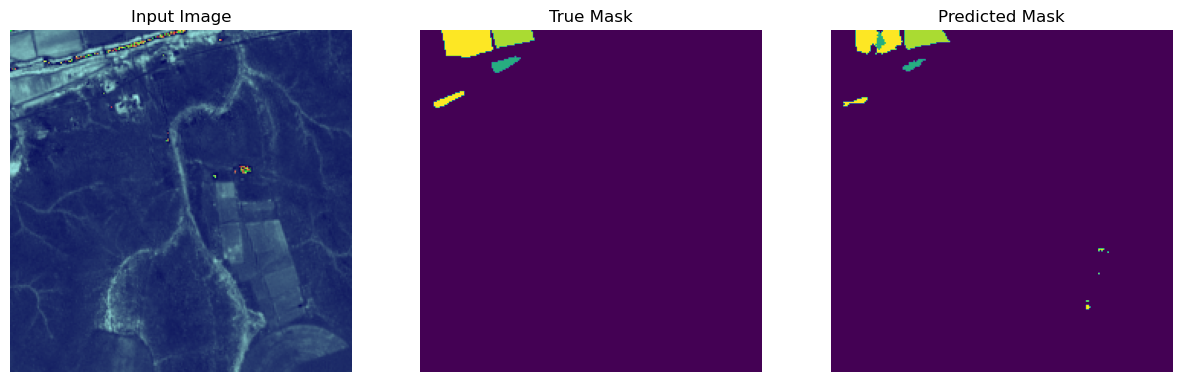

1/1 [==============================] - 0s 115ms/step
['images/tiled/labels_test/tile_2017-07-10_870.png']
[0 5 7 8]
1/1 [==============================] - 0s 153ms/step


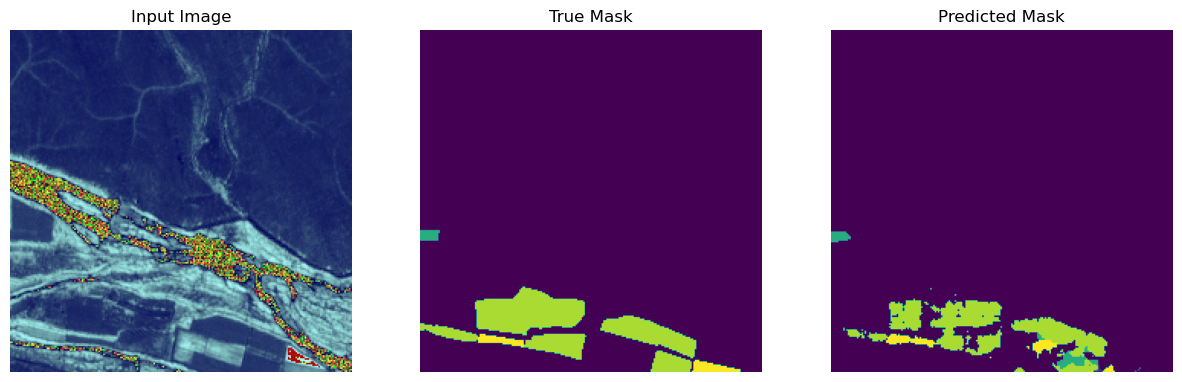

1/1 [==============================] - 0s 151ms/step
['images/tiled/labels_test/tile_2017-07-10_919.png']
[0 4 5 7 8]
1/1 [==============================] - 0s 146ms/step


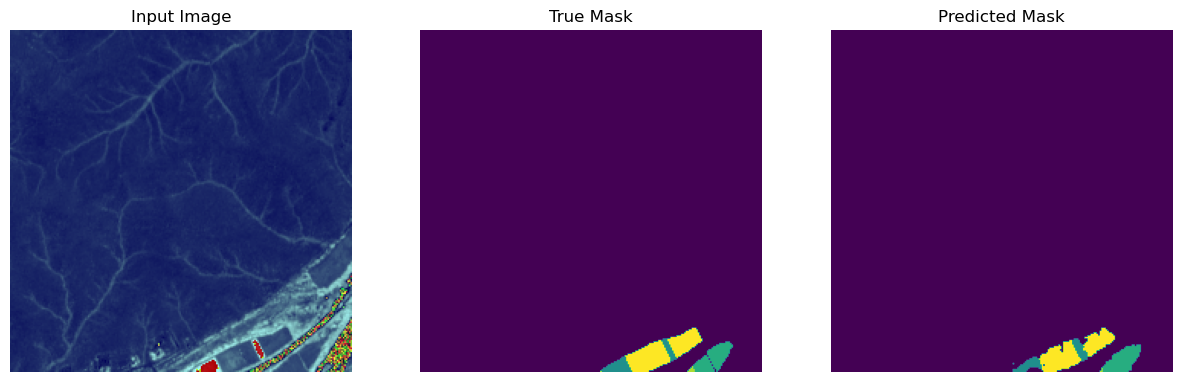

1/1 [==============================] - 0s 112ms/step
['images/tiled/labels_test/tile_2017-07-10_920.png']
[0 4 5 6 7 8]
1/1 [==============================] - 0s 117ms/step


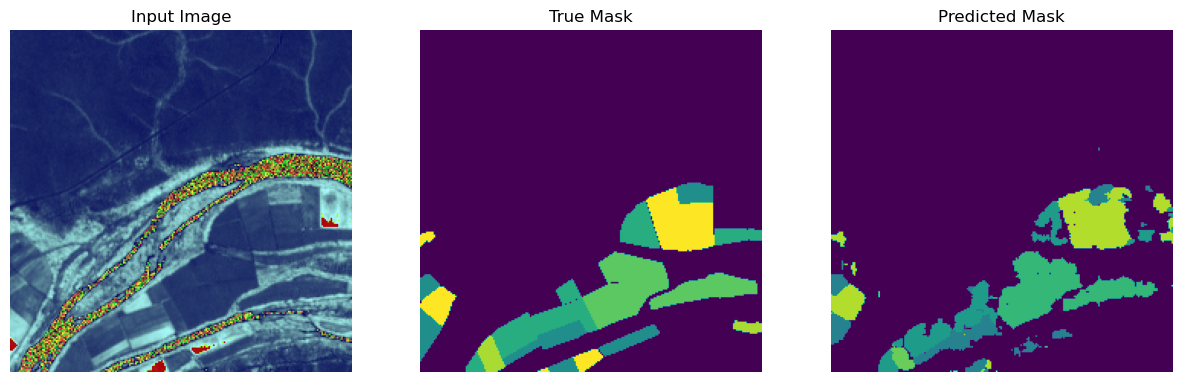

1/1 [==============================] - 0s 111ms/step
['images/tiled/labels_test/tile_2017-07-10_968.png']
[0 4 8]
1/1 [==============================] - 0s 96ms/step


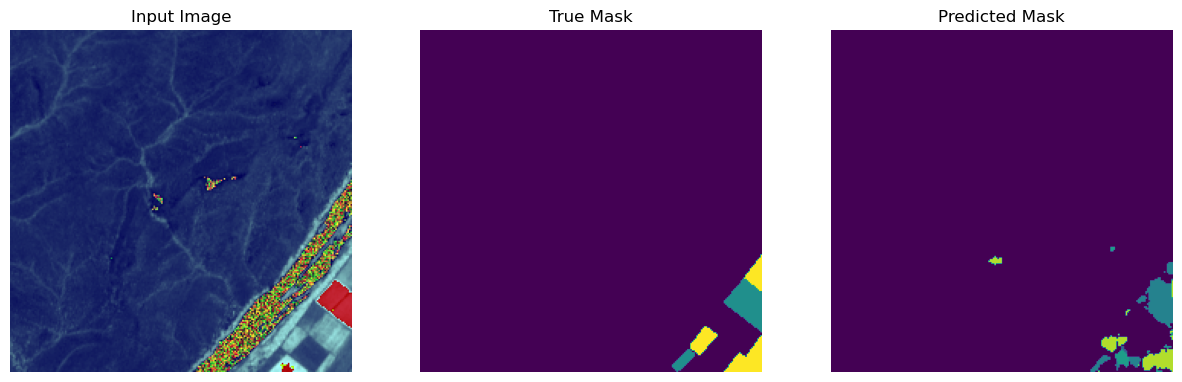

1/1 [==============================] - 0s 121ms/step
['images/tiled/labels_test/tile_2017-07-10_969.png']
[0 1 3 4 5 6 7 8]
1/1 [==============================] - 0s 103ms/step


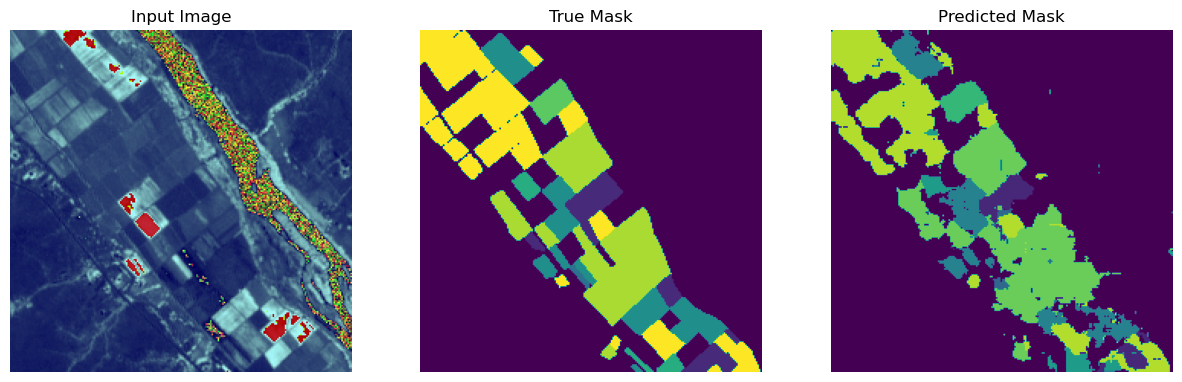

1/1 [==============================] - 0s 85ms/step
['images/tiled/labels_test/tile_2017-07-10_970.png']
[0 1 3 4 5 7 8]
1/1 [==============================] - 0s 72ms/step


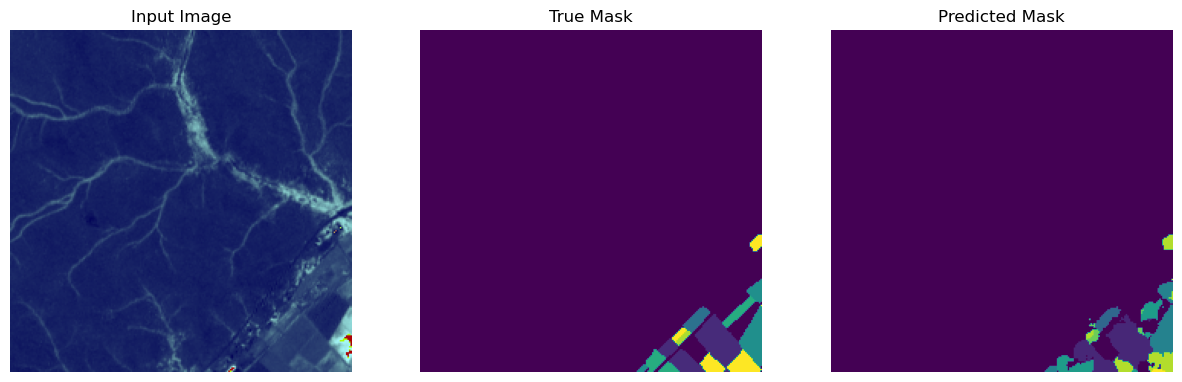

1/1 [==============================] - 0s 113ms/step
['images/tiled/labels_test/tile_2017-07-10_1017.png']
[0 4]
1/1 [==============================] - 0s 122ms/step


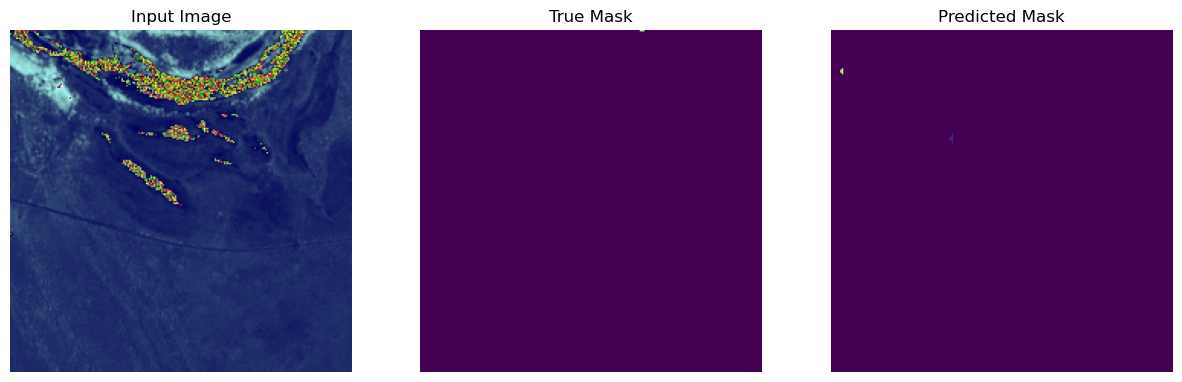

1/1 [==============================] - 0s 92ms/step
['images/tiled/labels_test/tile_2017-07-10_1018.png']
[0 1 4 5 6 7 8 9]
1/1 [==============================] - 0s 134ms/step


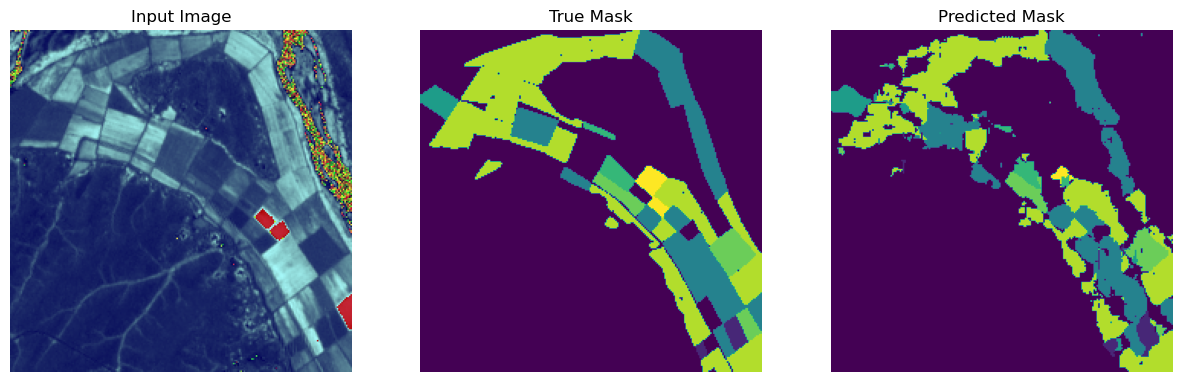

1/1 [==============================] - 0s 137ms/step
['images/tiled/labels_test/tile_2017-07-10_1019.png']
[0 4 8]
1/1 [==============================] - 0s 132ms/step


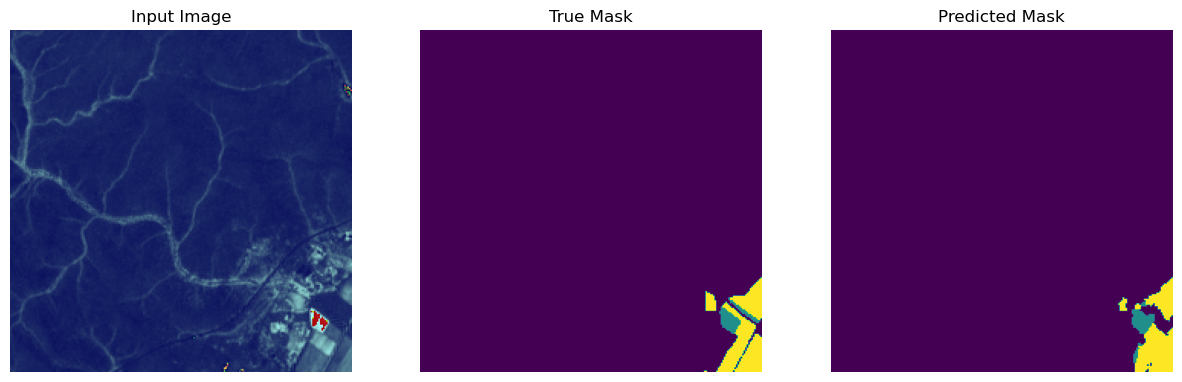

1/1 [==============================] - 0s 86ms/step
['images/tiled/labels_test/tile_2017-07-10_1068.png']
[0 4 5 6 8 9]
1/1 [==============================] - 0s 121ms/step


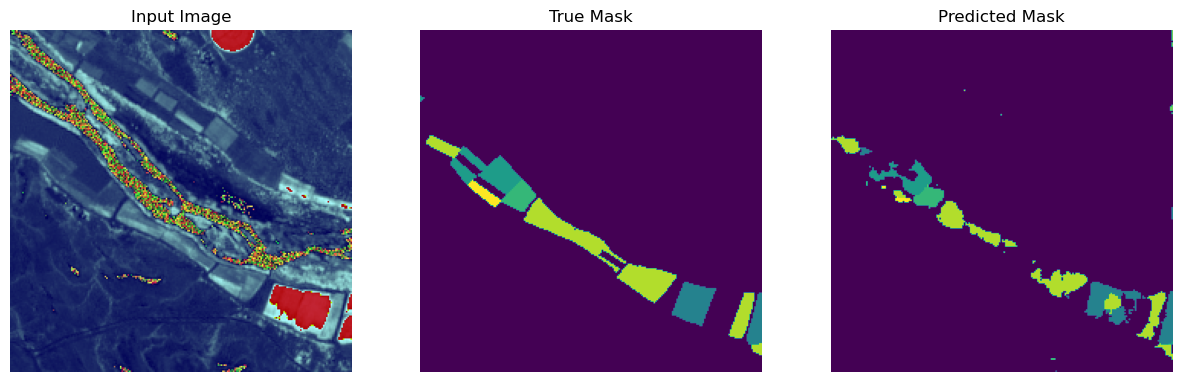

1/1 [==============================] - 0s 106ms/step
['images/tiled/labels_test/tile_2017-07-10_1118.png']
[0 1 2 4 7 8 9]
1/1 [==============================] - 0s 105ms/step


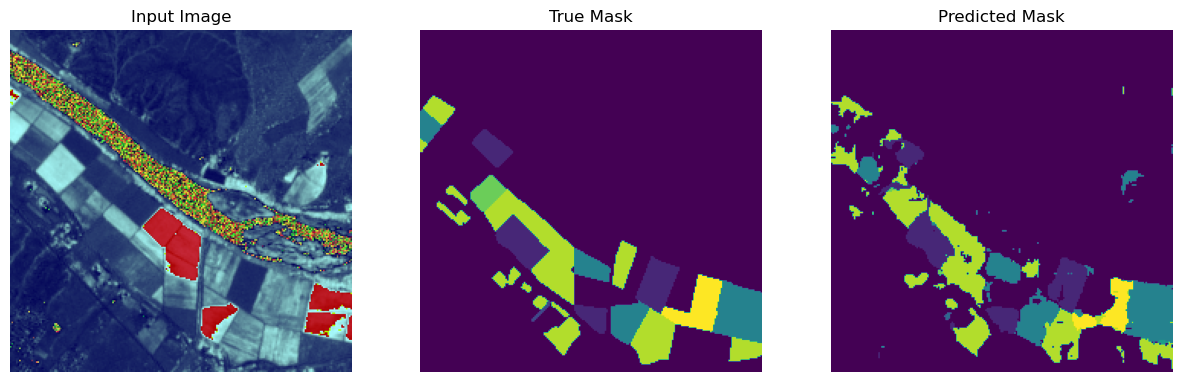

1/1 [==============================] - 0s 120ms/step
['images/tiled/labels_test/tile_2017-07-10_1167.png']
[0 1 4 8 9]
1/1 [==============================] - 0s 136ms/step


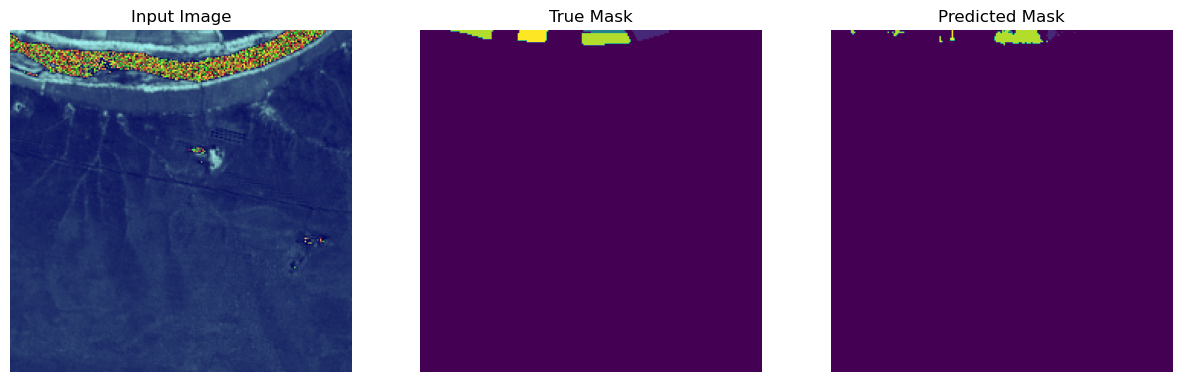

1/1 [==============================] - 0s 102ms/step
['images/tiled/labels_test/tile_2017-07-10_1168.png']
[0 1 4 5 6 7 8 9]
1/1 [==============================] - 0s 118ms/step


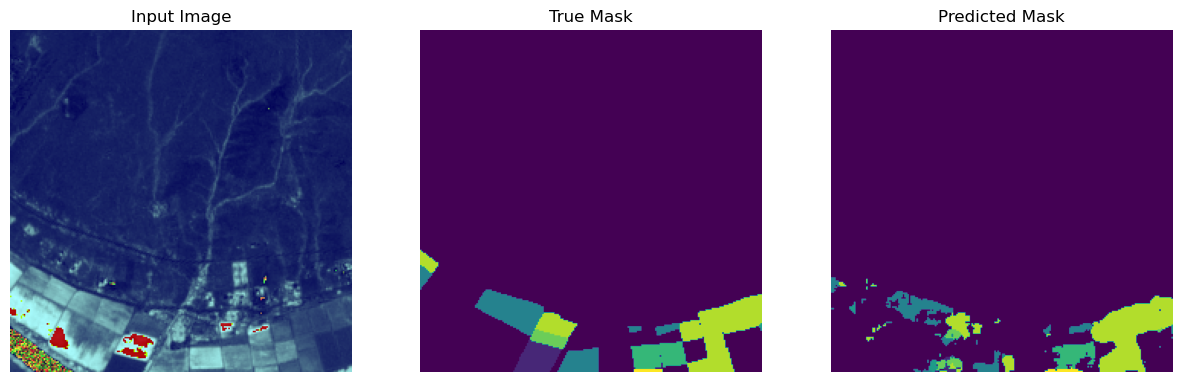

1/1 [==============================] - 0s 118ms/step
['images/tiled/labels_test/tile_2017-07-10_1218.png']
[0 1 4 5 8]
1/1 [==============================] - 0s 92ms/step


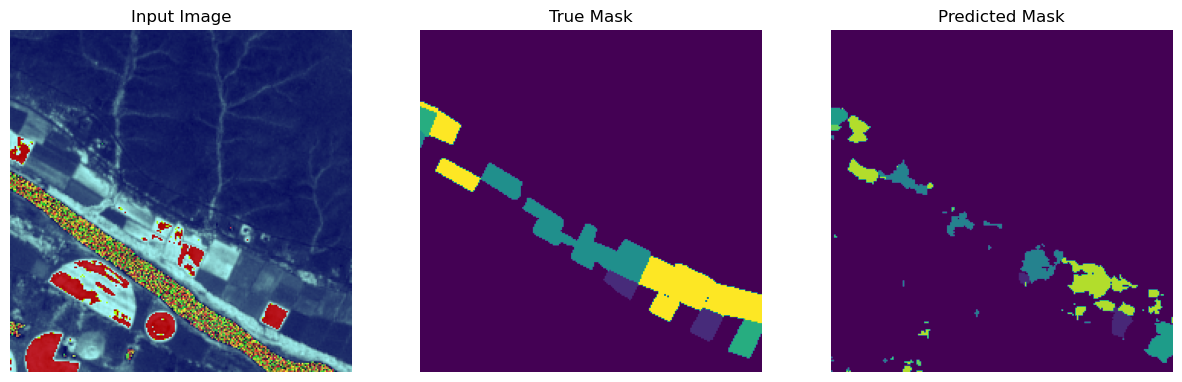

1/1 [==============================] - 0s 78ms/step
['images/tiled/labels_test/tile_2017-07-10_1268.png']
[0 1 2 4 5 8]
1/1 [==============================] - 0s 145ms/step


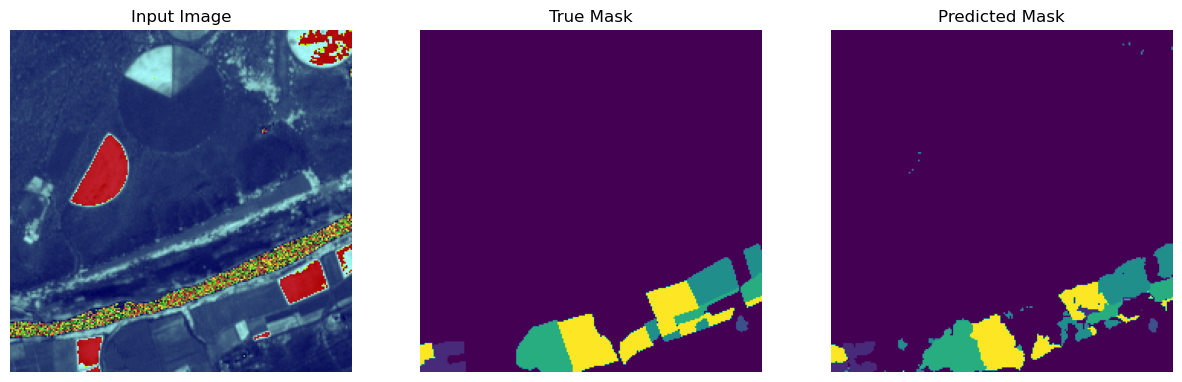

1/1 [==============================] - 0s 103ms/step
['images/tiled/labels_test/tile_2017-07-10_1269.png']
[0 1 3 4 5 8]
1/1 [==============================] - 0s 92ms/step


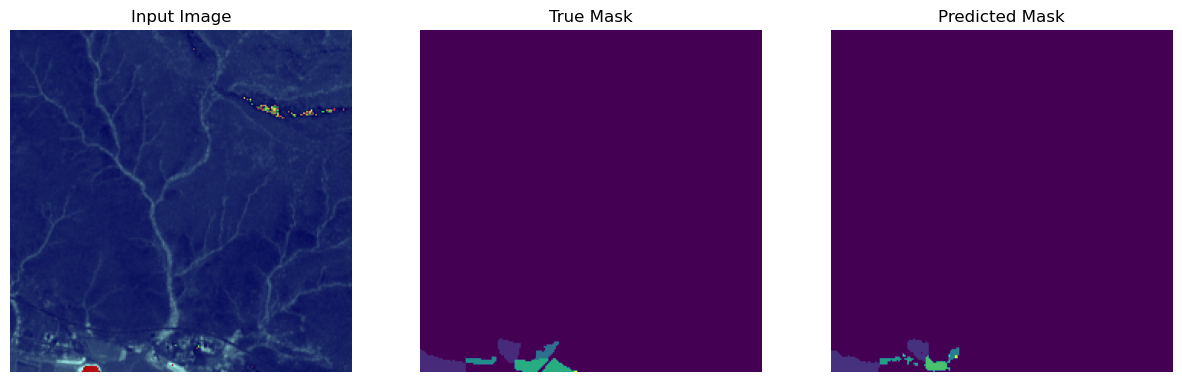

1/1 [==============================] - 0s 125ms/step
['images/tiled/labels_test/tile_2017-07-10_1318.png']
[0 1 4 8]
1/1 [==============================] - 0s 119ms/step


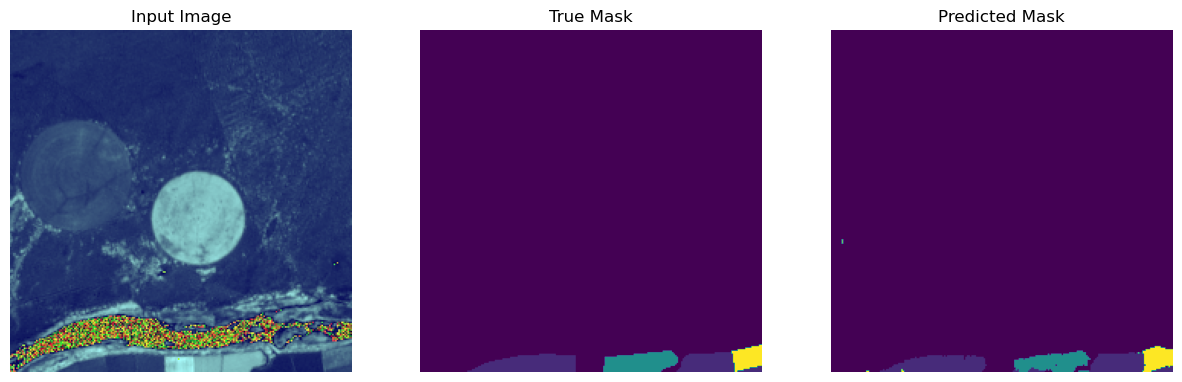

1/1 [==============================] - 0s 143ms/step


In [51]:
tiled_prediction_dir = os.path.join("",'predictions_test/')
if not os.path.exists(tiled_prediction_dir):
    os.makedirs(tiled_prediction_dir)

pred_masks = []
true_masks = []

for i in range(0, 20):
    img_num = i

    temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                                   foreground_list_y[img_num:img_num+1],
                                   preproc_fn=tr_preprocessing_fn,
                                   batch_size=1,
                                   shuffle=False)

    # Let's examine some of these augmented images

    iterator = iter(temp_ds)
    next_element = iterator.get_next()

    batch_of_imgs, label = next_element

    # Running next element in our graph will produce a batch of images

    sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]
    sample_mask_int = tf.dtypes.cast(sample_mask, tf.int32)
    true_masks.append(sample_mask_int)
    print(foreground_list_y[img_num:img_num+1])
    print(np.unique(sample_mask_int))

    # run and plot predicitions

    show_predictions()
    pred_mask = get_predictions()
    pred_masks.append(pred_mask)

    # save prediction images to file

    filename_split = os.path.splitext(foreground_list_x[img_num]) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    tf.keras.preprocessing.image.save_img(tiled_prediction_dir+'/'+basename+".png", pred_mask)

In [52]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = tf.reshape(pred_masks, [-1]) 
flat_truth = tf.reshape(true_masks, [-1]) 
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

In [53]:
# check values in predicted masks vs truth masks

check_preds = tf.keras.backend.eval(flat_preds)
check_truths = tf.keras.backend.eval(flat_truth)
print(np.unique(check_preds), np.unique(check_truths))

[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]


(9.5, -0.5)

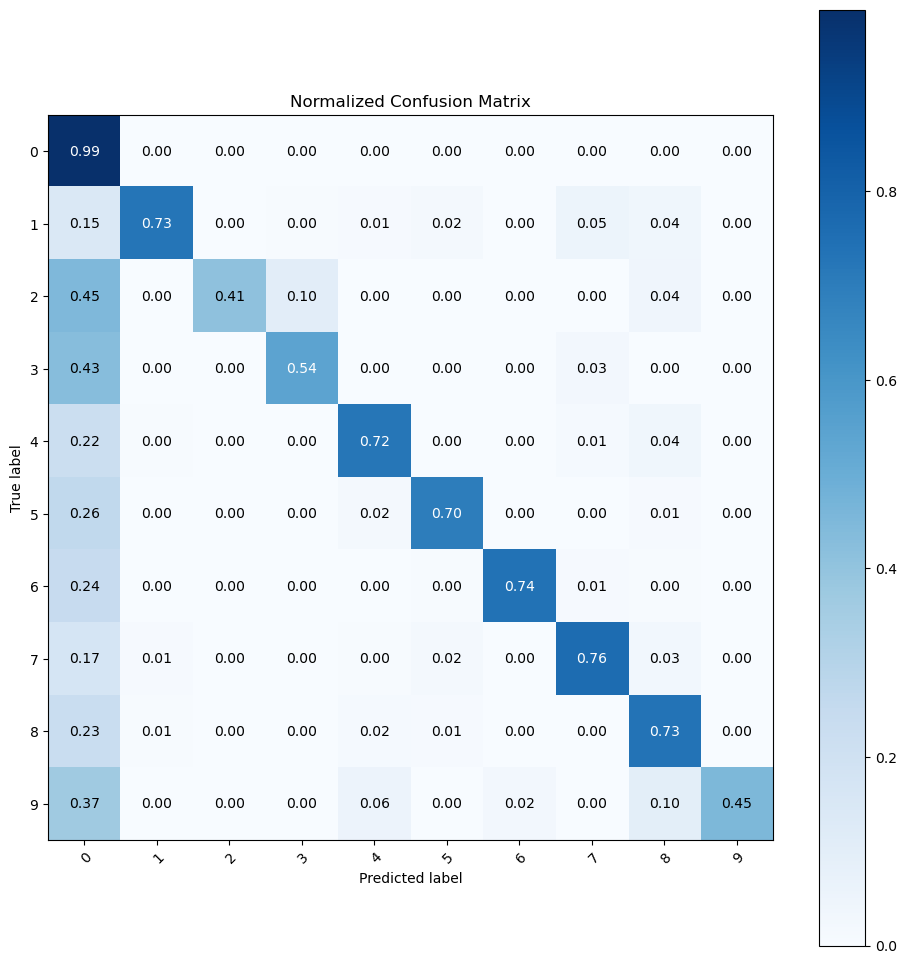

In [54]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

In [55]:
# compute f1 score
f1_score(flat_truth, flat_preds, average='macro')

0.7378756825102296